# Example of MLP VAE with MNIST dataset

In [1]:
# First install the library

# %pip install rapidae

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

#notebook_dir = os.path.abspath('')
#sys.path.append(os.path.join(notebook_dir, '..', 'src'))

from rapidae.pipelines.training import TrainingPipeline
from rapidae.models.vae.vae_model import VAE
from rapidae.models.base.default_architectures import Encoder_MLP, Decoder_MLP
from rapidae.data.utils import display_diff
from rapidae.data.datasets import load_MNIST
from keras import utils

# For reproducibility in Keras 3. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
utils.set_random_seed(1)

2024-01-11 20:58:40.405535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 20:58:40.405565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 20:58:40.406261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 20:58:40.411587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 20:58:41.137024: W tensorflow/compiler/tf2

# Download and preprocess the dataset

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

Train and test data are normalized.

We also need to convert the labels into one-hot encoding.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

x_train = x_train.reshape(x_train.shape[0], -1).astype("float32") / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype("float32") / 255

# Obtain number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2024-01-11 20:58:41 [INFO]: train-images-idx3-ubyte.gz already exists.
2024-01-11 20:58:41 [INFO]: train-labels-idx1-ubyte.gz already exists.
2024-01-11 20:58:41 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2024-01-11 20:58:41 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


### Model creation

In this example we are using a vanilla MLP variational autoencoder. 

In [5]:
# Model creation
model = VAE(input_dim=x_train.shape[1], latent_dim=32,
            encoder=Encoder_MLP, decoder=Decoder_MLP, layers_conf=[64])

2024-01-11 20:58:41 [INFO]: No specific dowstream task has been selected


### Training pipeline

Define the training pipeline. There you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc.
Here you can define callbacks to the model.
Also the pipeline's name can be customized to facilitate the identification of the corresponding folder with the saved models inside output_dir folder.

In [6]:
pipe = TrainingPipeline(name='training_pipeline_mnist_mlp_vae', learning_rate=0.01,
                        model=model, num_epochs=40, batch_size=128)

trained_model = pipe(x=x_train, y=x_train)

2024-01-11 20:58:41 [INFO]: +++ training_pipeline_mnist_mlp_vae +++
2024-01-11 20:58:41 [INFO]: Creating folder in ../output_dir/training_pipeline_mnist_mlp_vae_2024-01-11_20-58-41


Epoch 1/40

Epoch 1: loss improved from inf to 0.09324, saving model to ../output_dir/training_pipeline_mnist_mlp_vae_2024-01-11_20-58-41/model.weights.h5
469/469 - 2s - 5ms/step - kl_loss: 0.0236 - loss: 0.0932 - reconstruction_loss: 0.0696
Epoch 2/40

Epoch 2: loss improved from 0.09324 to 0.06775, saving model to ../output_dir/training_pipeline_mnist_mlp_vae_2024-01-11_20-58-41/model.weights.h5
469/469 - 2s - 5ms/step - kl_loss: 1.9597e-07 - loss: 0.0677 - reconstruction_loss: 0.0677
Epoch 3/40

Epoch 3: loss improved from 0.06775 to 0.06761, saving model to ../output_dir/training_pipeline_mnist_mlp_vae_2024-01-11_20-58-41/model.weights.h5
469/469 - 2s - 5ms/step - kl_loss: 1.8123e-07 - loss: 0.0676 - reconstruction_loss: 0.0676
Epoch 4/40

Epoch 4: loss improved from 0.06761 to 0.06757, saving model to ../output_dir/training_pipeline_mnist_mlp_vae_2024-01-11_20-58-41/model.weights.h5
469/469 - 2s - 5ms/step - kl_loss: 1.7831e-07 - loss: 0.0676 - reconstruction_loss: 0.0676
Epoch 5/

### Evaluation step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


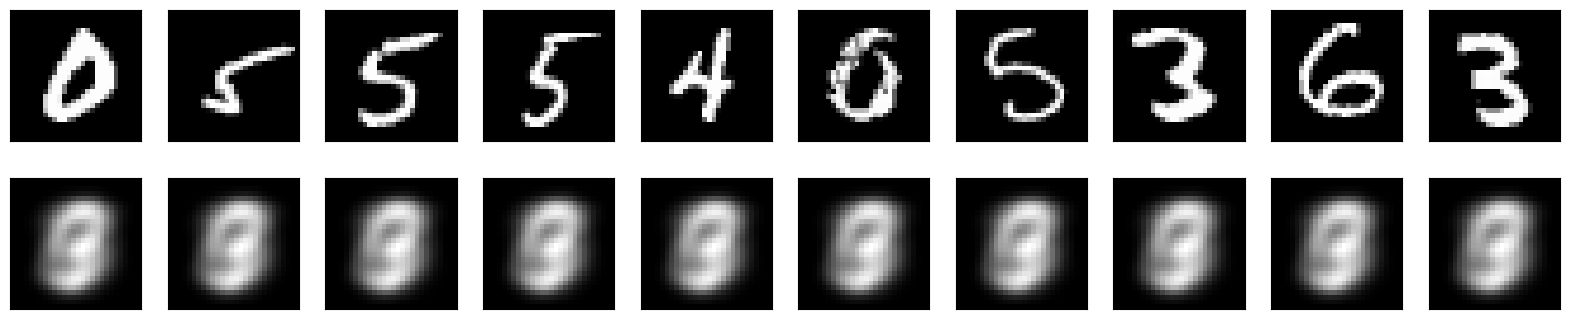

In [7]:
y_hat = trained_model.predict(x_test)

display_diff(x_test, y_hat['recon'])